## CNN 모델

In [2]:
# 필요한 라이브러리 설치
!pip install torch torchvision matplotlib numpy

In [3]:
# PyTorch 및 관련 라이브러리 불러오기
# 라이브러리 불러오기
import torch
# 라이브러리 불러오기
import torchvision
# 라이브러리 불러오기
import torchvision.transforms as transforms
# 라이브러리 불러오기
import torch.nn as nn
# 라이브러리 불러오기
import torch.optim as optim
# 라이브러리 불러오기
from torch.utils.data import DataLoader
# 라이브러리 불러오기
from torchvision.datasets import ImageFolder
# 라이브러리 불러오기
import matplotlib.pyplot as plt
# 라이브러리 불러오기
import os

In [4]:
# 데이터셋 불러오기
# 라이브러리 불러오기
from torchvision import datasets

data_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = datasets.ImageFolder(root="sample_data/train", transform=data_transforms)
test_dataset = datasets.ImageFolder(root="sample_data/test", transform=data_transforms)

In [5]:
# 라이브러리 불러오기
from torch.utils.data import DataLoader  # PyTorch 데이터 로딩 유틸리티

# 1️⃣ DataLoader 설정 (배치 크기: 32)
# 배치 사이즈의 경우 임의로 조정가능
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)  # 학습 데이터 로더 (랜덤 셔플)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)  # 테스트 데이터 로더 (순차적 로드)

# 2️⃣ 데이터 확인 (첫 번째 배치만 출력)
for images, labels in train_loader:
    print(f"✅ 데이터 로드 성공! 이미지 크기: {images.shape}, 레이블 크기: {labels.shape}")
    break  # 한 배치만 확인하고 루프 종료

✅ 데이터 로드 성공! 이미지 크기: torch.Size([32, 3, 224, 224]), 레이블 크기: torch.Size([32])


In [6]:
# 라이브러리 불러오기
import torch.nn.functional as F  # 활성화 함수 추가

# 📌 CNN 모델 정의 (Dropout 포함)
class FoodCNN(nn.Module):
    def __init__(self, num_classes, dropout_rate=0.5):  # Dropout 하이퍼파라미터 추가
        super(FoodCNN, self).__init__()

        # 합성곱(Convolutional) 레이어 정의
        self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

        # 풀링(Pooling) 레이어
        self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

        # 완전 연결(Fully Connected) 레이어 (Dropout 추가)
        self.fc1 = nn.Linear(in_features=128 * 16 * 16, out_features=512)
        self.dropout = nn.Dropout(p=dropout_rate)  # Dropout 레이어 추가
        self.fc2 = nn.Linear(in_features=512, out_features=num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))

        x = x.view(x.size(0), -1)  # Flatten
        x = F.relu(self.fc1(x))
        x = self.dropout(x)  # Dropout 적용
        x = self.fc2(x)

        return x

# 드롭아웃 비율 설정 가능하도록 변경
dropout_rate = 0.5  # 하이퍼파라미터로 설정 가능
# CNN 모델 생성
model = FoodCNN(num_classes=5, dropout_rate=dropout_rate)


In [7]:
# 📌 GPU 사용 가능하면 GPU로 이동 (그렇지 않으면 CPU 사용)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)  # 모델을 해당 장치(GPU 또는 CPU)로 이동

# 📌 손실 함수 정의 (다중 클래스 분류 문제이므로 CrossEntropyLoss 사용)
criterion = nn.CrossEntropyLoss()  # 다중 클래스 분류에 적합한 손실 함수

# 📌 옵티마이저 정의 (Adam 사용, 학습률: 0.001) 
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=0.0001)

In [8]:
model.fc1 = nn.Linear(100352, 512)  # 기존 32768 → 100352로 수정

In [9]:
num_epochs = 30  # 학습할 에포크 수

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # GPU로 이동

        optimizer.zero_grad()  # 기울기 초기화
        outputs = model(images)  # 모델 예측
        loss = criterion(outputs, labels)  # 손실 계산
        loss.backward()  # 역전파
        optimizer.step()  # 가중치 업데이트

        running_loss += loss.item()

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {running_loss/len(train_loader):.4f}")

print("✅ 학습 완료!")

Epoch [1/30], Loss: 1.6105
Epoch [2/30], Loss: 1.5969
Epoch [3/30], Loss: 1.5873
Epoch [4/30], Loss: 1.5410
Epoch [5/30], Loss: 1.4130
Epoch [6/30], Loss: 1.2994
Epoch [7/30], Loss: 1.1303
Epoch [8/30], Loss: 1.1604
Epoch [9/30], Loss: 1.1110
Epoch [10/30], Loss: 1.0931
Epoch [11/30], Loss: 0.9947
Epoch [12/30], Loss: 0.9663
Epoch [13/30], Loss: 0.9291
Epoch [14/30], Loss: 0.8828
Epoch [15/30], Loss: 0.8644
Epoch [16/30], Loss: 0.8165
Epoch [17/30], Loss: 0.7054
Epoch [18/30], Loss: 0.6523
Epoch [19/30], Loss: 0.6052
Epoch [20/30], Loss: 0.6668
Epoch [21/30], Loss: 0.5733
Epoch [22/30], Loss: 0.5964
Epoch [23/30], Loss: 0.5841
Epoch [24/30], Loss: 0.5502
Epoch [25/30], Loss: 0.5068
Epoch [26/30], Loss: 0.4780
Epoch [27/30], Loss: 0.4835
Epoch [28/30], Loss: 0.4324
Epoch [29/30], Loss: 0.4200
Epoch [30/30], Loss: 0.4250
✅ 학습 완료!


In [10]:
model.eval()
correct = 0
total = 0

with torch.no_grad():  # 평가 시에는 기울기 계산 X
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

accuracy = 100 * correct / total
print(f"✅ 테스트 정확도: {accuracy:.2f}%")

✅ 테스트 정확도: 68.00%


### 과적합 여부 확인

Epoch [1/20] -> Train Loss: 0.3753, Val Loss: 1.0133, Train Acc: 85.14%, Val Acc: 72.00%
Epoch [2/20] -> Train Loss: 0.3823, Val Loss: 1.0206, Train Acc: 87.15%, Val Acc: 64.00%
Epoch [3/20] -> Train Loss: 0.4107, Val Loss: 1.0790, Train Acc: 85.14%, Val Acc: 72.00%
Epoch [4/20] -> Train Loss: 0.3650, Val Loss: 0.9447, Train Acc: 84.74%, Val Acc: 68.00%
Epoch [5/20] -> Train Loss: 0.3537, Val Loss: 0.9474, Train Acc: 86.35%, Val Acc: 68.00%
Epoch [6/20] -> Train Loss: 0.3252, Val Loss: 1.0791, Train Acc: 88.35%, Val Acc: 76.00%
Epoch [7/20] -> Train Loss: 0.3606, Val Loss: 1.0263, Train Acc: 86.75%, Val Acc: 68.00%
Epoch [8/20] -> Train Loss: 0.3320, Val Loss: 1.0451, Train Acc: 85.54%, Val Acc: 68.00%
Epoch [9/20] -> Train Loss: 0.3017, Val Loss: 1.0606, Train Acc: 87.95%, Val Acc: 64.00%
Epoch [10/20] -> Train Loss: 0.2708, Val Loss: 1.0105, Train Acc: 90.76%, Val Acc: 68.00%
Epoch [11/20] -> Train Loss: 0.2995, Val Loss: 1.0090, Train Acc: 88.76%, Val Acc: 64.00%
Epoch [12/20] -> Tr

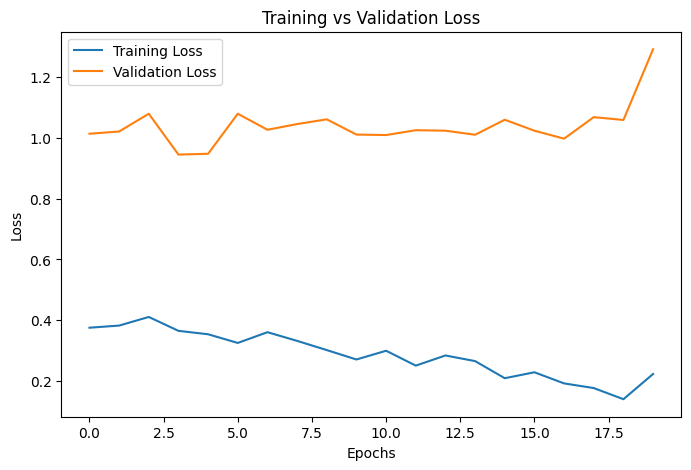

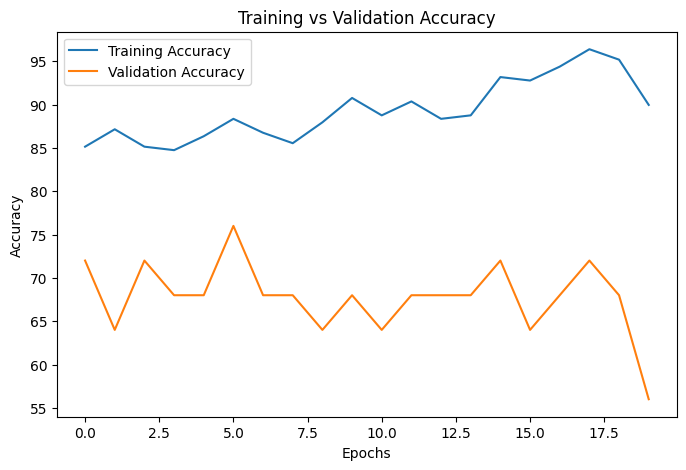

In [12]:
# 라이브러리 불러오기
import matplotlib.pyplot as plt

# 훈련 & 검증 손실 시각화
def plot_loss_curve(train_losses, val_losses):
# 그래프 시각화
    plt.figure(figsize=(8,5))
# 그래프 시각화
    plt.plot(train_losses, label="Training Loss")
# 그래프 시각화
    plt.plot(val_losses, label="Validation Loss")
# 그래프 시각화
    plt.xlabel("Epochs")
# 그래프 시각화
    plt.ylabel("Loss")
# 그래프 시각화
    plt.legend()
# 그래프 시각화
    plt.title("Training vs Validation Loss")
# 그래프 시각화
    plt.show()

# 훈련 & 검증 정확도 시각화
def plot_accuracy_curve(train_acc, val_acc):
# 그래프 시각화
    plt.figure(figsize=(8,5))
# 그래프 시각화
    plt.plot(train_acc, label="Training Accuracy")
# 그래프 시각화
    plt.plot(val_acc, label="Validation Accuracy")
# 그래프 시각화
    plt.xlabel("Epochs")
# 그래프 시각화
    plt.ylabel("Accuracy")
# 그래프 시각화
    plt.legend()
# 그래프 시각화
    plt.title("Training vs Validation Accuracy")
# 그래프 시각화
    plt.show()

# ✅ 훈련 과정에서 loss 및 accuracy 저장
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

num_epochs = 20  # 예제: 20 epochs

for epoch in range(num_epochs):
    model.train()
    train_loss = 0
    correct = 0
    total = 0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        outputs = model(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item()
        
        _, predicted = torch.max(outputs, 1)
        correct += (predicted == labels).sum().item()
        total += labels.size(0)

    avg_train_loss = train_loss / len(train_loader)
    train_acc = 100 * correct / total

    # 검증 과정
    model.eval()
    val_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            
            _, predicted = torch.max(outputs, 1)
            correct += (predicted == labels).sum().item()
            total += labels.size(0)

    avg_val_loss = val_loss / len(test_loader)
    val_acc = 100 * correct / total

    train_losses.append(avg_train_loss)
    val_losses.append(avg_val_loss)
    train_accuracies.append(train_acc)
    val_accuracies.append(val_acc)

    print(f"Epoch [{epoch+1}/{num_epochs}] -> Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Acc: {val_acc:.2f}%")

# ✅ 최종 시각화
plot_loss_curve(train_losses, val_losses)
plot_accuracy_curve(train_accuracies, val_accuracies)


In [ ]:
loss_gap = avg_val_loss - avg_train_loss
if loss_gap > 0.1:  # 차이가 0.1 이상이면 과적합 가능성이 높음
    print("⚠️ 과적합 가능성이 높습니다!")

⚠️ 과적합 가능성이 높습니다!


In [ ]:
accuracy_gap = train_acc - val_acc
if accuracy_gap > 15:  # 15% 이상 차이 나면 과적합 가능성이 있음
    print("⚠️ 과적합 가능성이 높습니다!")

⚠️ 과적합 가능성이 높습니다!
